## scVelo: Dynamical Modeling
https://scvelo.readthedocs.io/DynamicalModeling.html

最終更新日: 2023/10/1

- ここでは全体的な転写ダイナミクスを求めるために一般化力学モデル (generalized dynamical model) を用います。
- これにより、潜在時間や潜在的なドライバー遺伝子の同定など、いくつかの付加的な知見が得られます。
- 前回のチュートリアルと同様に、pancreasの内分泌系の発生をデータに用います。

In [2]:
import scvelo as scv
scv.logging.print_version()

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

Running scvelo 0.2.5 (python 3.8.16) on 2023-10-01 18:11.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


### データの準備
前準備として、HVGの選択、総サイズによる遺伝子発現量の正規化・対数化、速度推定のためのモーメント計算を実行します。
詳しい説明は前のチュートリアルを参照。

In [3]:
adata = scv.datasets.pancreas()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


### Dynamical Model

スプライシング動態の完全な転写ダイナミクスを学習するために力学モデルを実行する。

このモデルは尤度ベースの期待値最大化フレームワークでを用いて、反応速度と細胞固有の潜在変数、すなわち転写状態と細胞内潜在時間のパラメータを反復的に推定することで求められます。これにより、各遺伝子のスプライスされていない／スプライスされた位相の軌跡を学習します。

In [4]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

recovering dynamics (using 1/40 cores)


  0%|          | 0/1298 [00:00<?, ?gene/s]

    finished (0:10:52) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


動的モデルの実行には時間がかかります。そこで、`adata.write('data/pancreas.h5ad')`で結果を保存し、後で`adata = scv.read('data/pancreas.h5ad')`で読み込むようにします。

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


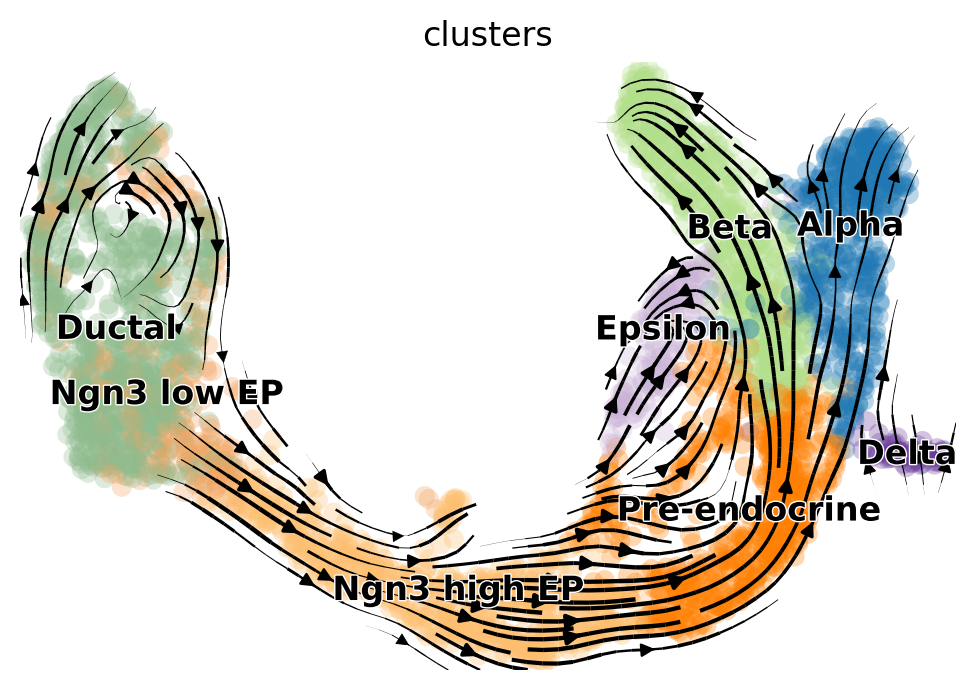

In [5]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

### Kinetic rate paramters

RNAの転写、スプライシング、分解の速度は、実験データを必要とせずに推定できます。
これらは、細胞の同一性や表現型の不均一性をよりよく理解するために有用です。

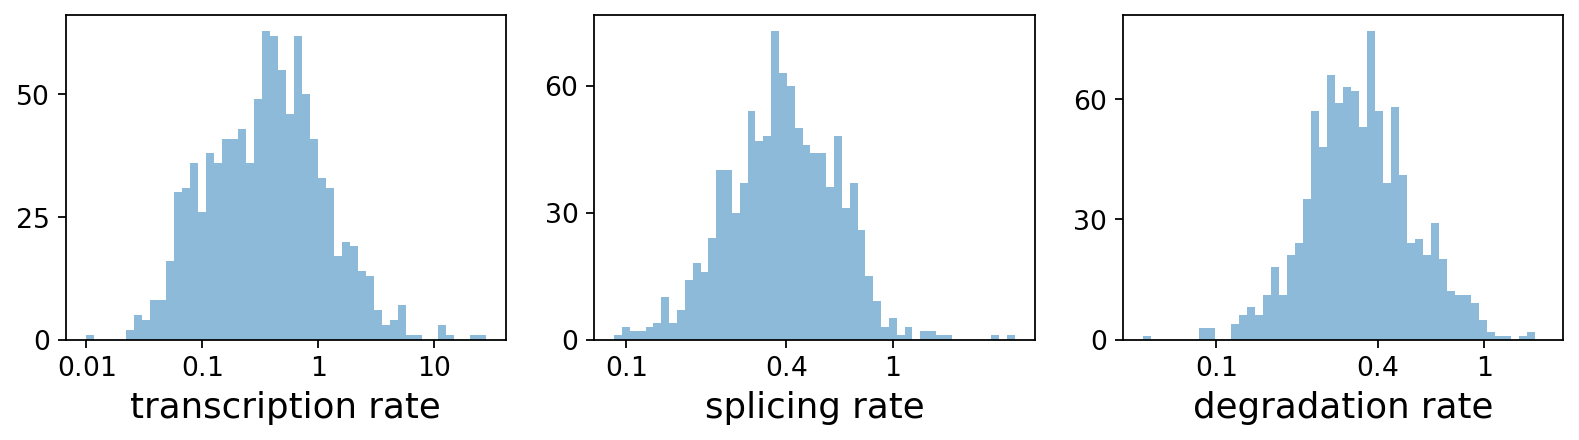

,fit_r2,fit_alpha,fit_beta,fit_gamma,fit_t_,fit_scaling,fit_std_u,fit_std_s,fit_likelihood,fit_u0,fit_s0,fit_pval_steady,fit_steady_u,fit_steady_s,fit_variance,fit_alignment_scaling
index,,,,,,,,,,,,,,,,
Sntg1,0.401981,0.015726,0.005592,0.088792,23.404254,42.849447,1.029644,0.030838,0.406523,0.0,0.0,0.159472,2.470675,0.094304,0.149138,5.355590
Snhg6,0.125072,0.389126,2.981982,0.260322,6.981600,0.070368,0.037113,0.245248,0.243441,0.0,0.0,0.403409,0.106128,0.596630,0.762252,2.037296
Sbspon,0.624803,0.464865,2.437113,0.379645,3.785993,0.154771,0.058587,0.178859,0.252135,0.0,0.0,0.182088,0.164805,0.430623,0.674312,1.193015
Mcm3,0.292389,3.096367,39.995796,0.638543,2.049463,0.013943,0.016253,0.673142,0.228207,0.0,0.0,0.467683,0.051432,1.927742,0.687468,0.887607
Fam135a,0.384662,0.172335,0.118088,0.204538,11.239574,1.124040,0.356525,0.149868,0.283343,0.0,0.0,0.387921,1.345830,0.393197,0.671096,3.390194


In [7]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()

推定される遺伝子特異的パラメータ群は以下の通りです：
- 転写率（`fit_alpha`）
- スプライシング（`fit_beta`）
- 分解（`fit_gamma`）
- スイッチングタイムポイント（`fit_t_`）
- 過少に代表される未スプライスリードを調整するためのスケーリングパラメータ（`fit_scaling`）
- 未スプライスリードとスプライスリードの標準偏差（`fit_std_u、fit_std_s`）
- 遺伝子尤度（`fit_likelihood`）
- 推論された定常状態レベル（`fit_steady_u`, `fit_steady_s`）
- それに対応する p値（`fit_pval_steady_u`, `fit_pval_steady_s`）
- モデル全体の分散（`fit_variance`）
- 遺伝子ごとの潜在時間を普遍的な遺伝子共有潜 在時間に揃えるためのスケーリング係数（`fit_alignment_scaling`）。

### 潜在時間
力学的モデルは、基礎となる細胞プロセスの潜在時間を復元します。この潜伏時間は細胞の内部時計を表し、細胞が分化する際に経験する実時間を転写ダイナミクスのみに基づいて近似します。

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


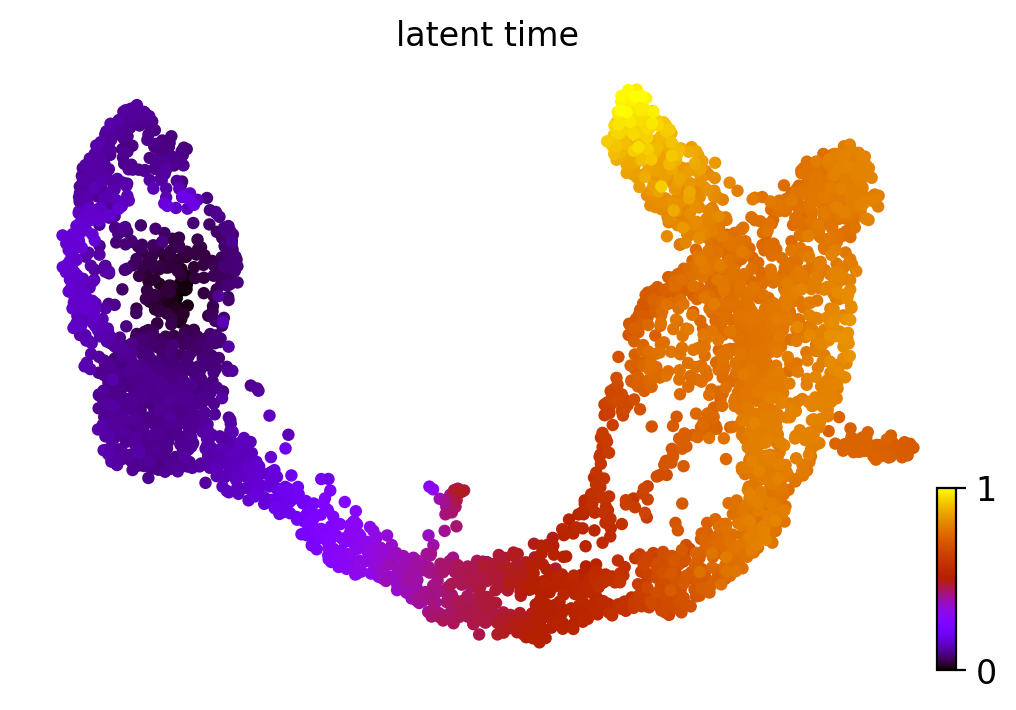

In [8]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

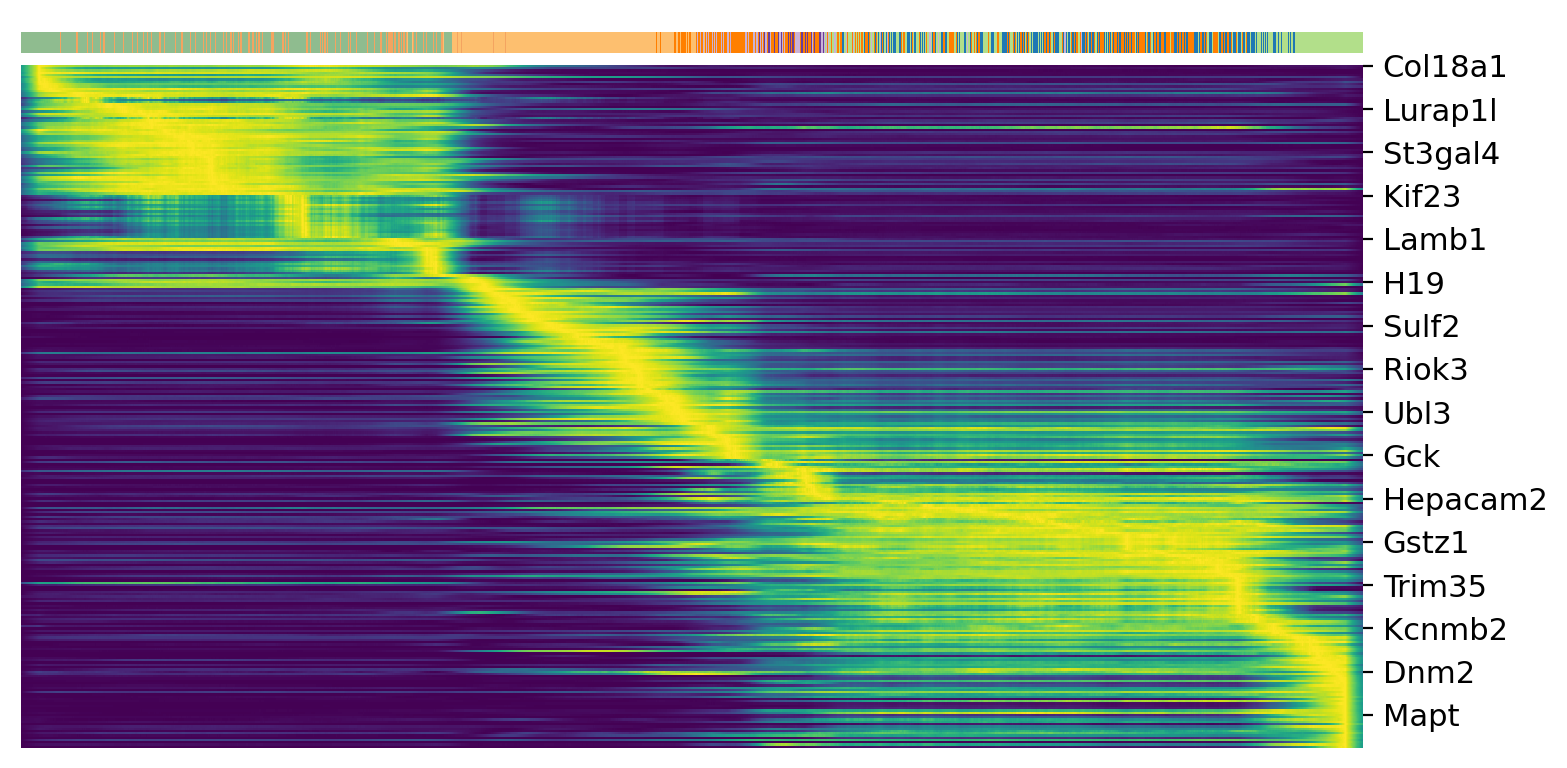

In [9]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

### Top-likelihood genes
ドライバー遺伝子は顕著な動的挙動を示し、動的モデルでの高い尤度による特徴付けによって、系統的に検出されます。

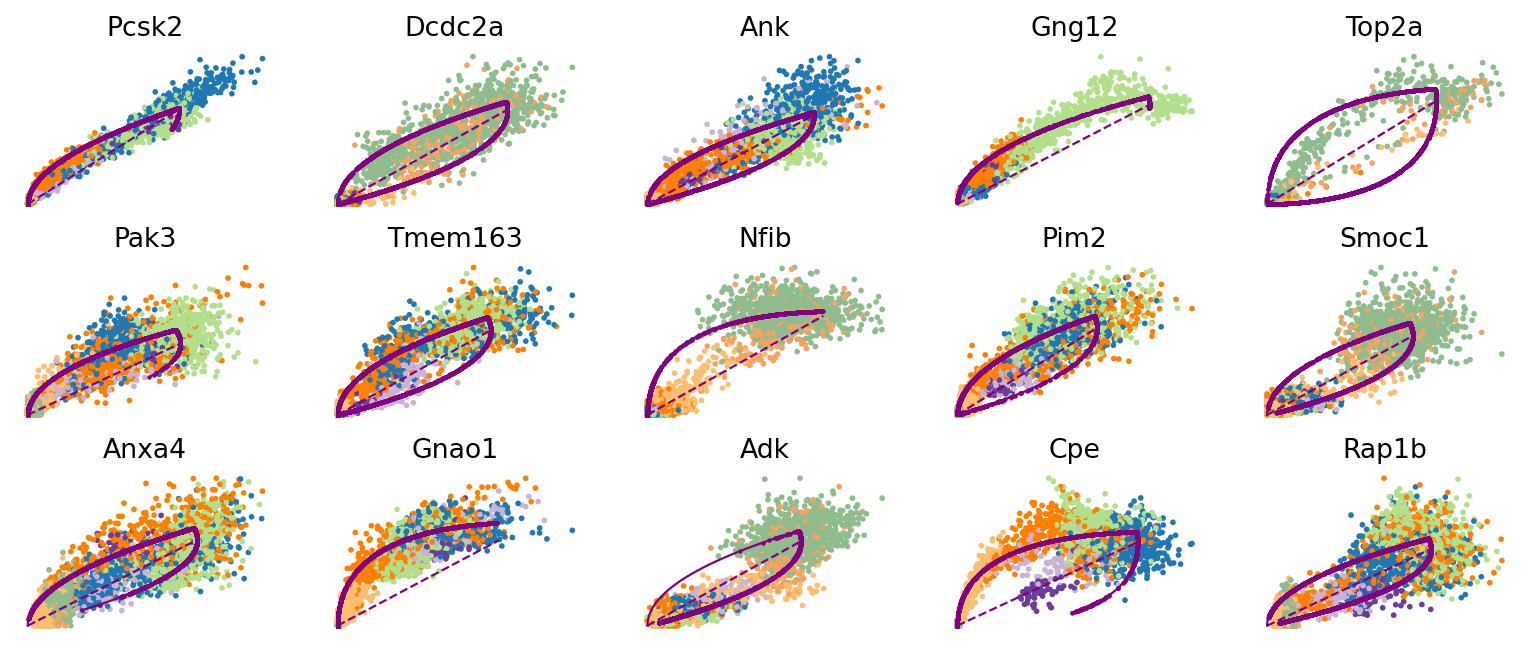

In [10]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, frameon=False)

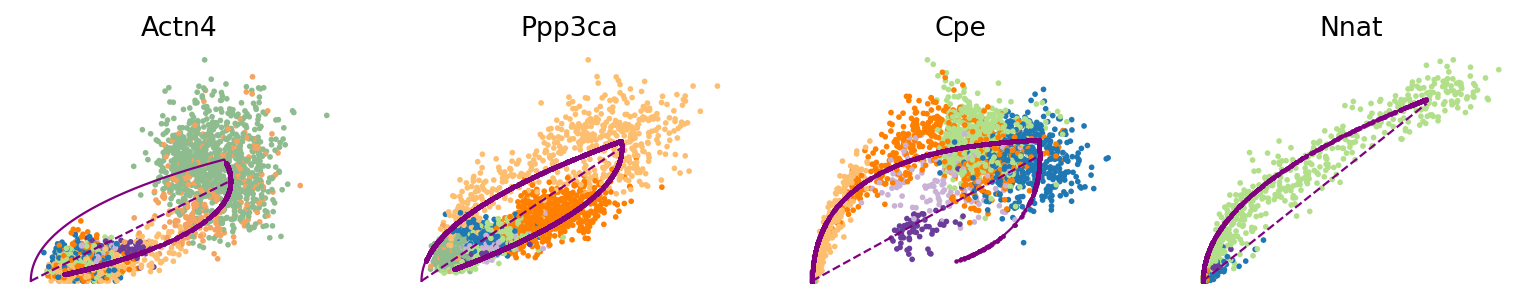

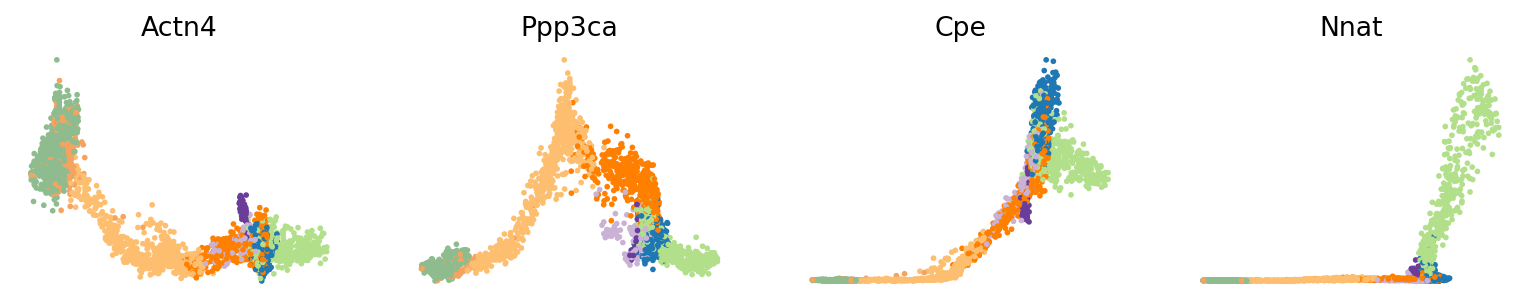

In [11]:
var_names = ['Actn4', 'Ppp3ca', 'Cpe', 'Nnat']
scv.pl.scatter(adata, var_names, frameon=False)
scv.pl.scatter(adata, x='latent_time', y=var_names, frameon=False)

### Cluster-specific top-likelihood genes

さらに、部分的な遺伝子の尤度を細胞の各クラスタに対して計算することで、潜在的なドライバーをクラスタごとに特定することができます。

In [12]:
scv.tl.rank_dynamical_genes(adata, groupby='clusters')
df = scv.get_df(adata, 'rank_dynamical_genes/names')
df.head(5)

ranking genes by cluster-specific likelihoods
    finished (0:00:03) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


,Ductal,Ngn3 low EP,Ngn3 high EP,Pre-endocrine,Beta,Alpha,Delta,Epsilon
0,Dcdc2a,Dcdc2a,Rbfox3,Abcc8,Pcsk2,Cpe,Pcsk2,Tox3
1,Top2a,Adk,Mapre3,Tmem163,Ank,Gnao1,Rap1b,Rnf130
2,Nfib,Mki67,Btbd17,Gnao1,Tmem163,Pak3,Pak3,Meis2
3,Wfdc15b,Rap1gap2,Sulf2,Ank,Tspan7,Pim2,Abcc8,Adk
4,Cdk1,Top2a,Tcp11,Tspan7,Map1b,Map1b,Klhl32,Rap1gap2


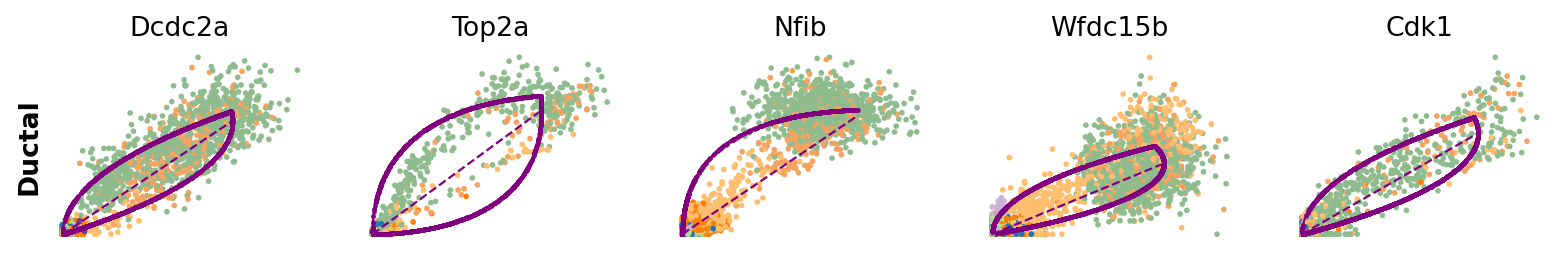

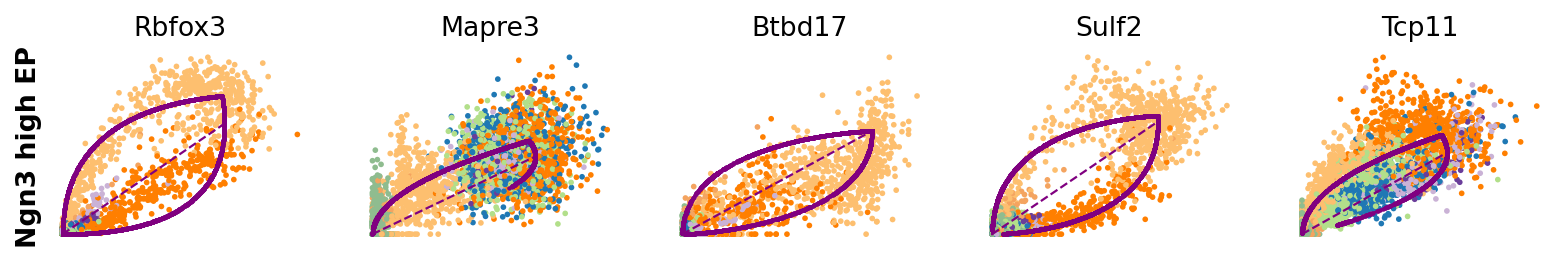

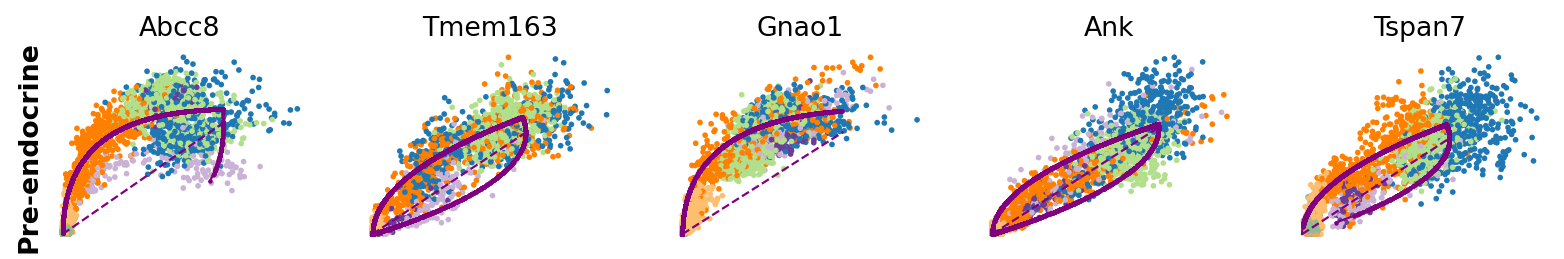

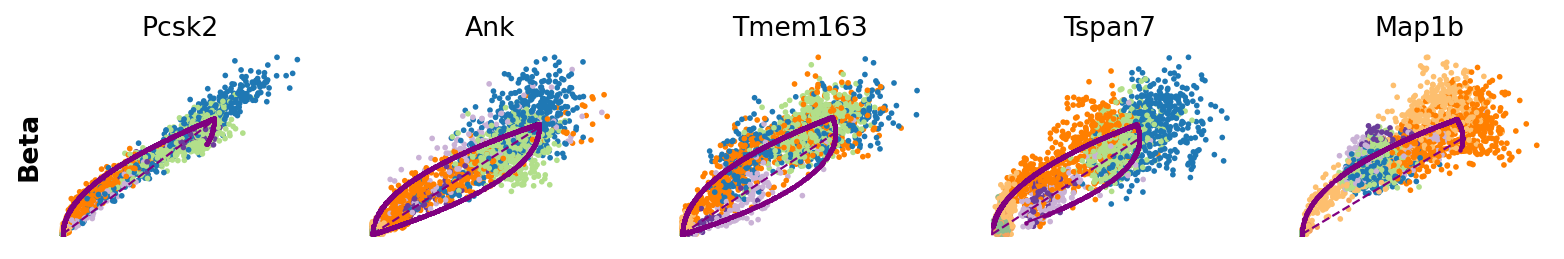

In [13]:
for cluster in ['Ductal', 'Ngn3 high EP', 'Pre-endocrine', 'Beta']:
    scv.pl.scatter(adata, df[cluster][:5], ylabel=cluster, frameon=False)

In [14]:
import session_info
session_info.show()